### İş Problemi:

El yapımı kışlık ürünler satan bir firma, sürdürülebilirlik kavramına önem verdiği için tasarımlarında çift taraflı kullanım olanağı sağlayan ürünler üretmektedir. Firma, çift tasarımlı atkıyı online reklamlarında kullanmak istemektedir. 
Bir tarafı kareli ve diğer tarafı düz çizgi tasarımlı olan bu atkının statik görselinin ve hareketli görselinin online reklam kampanyalarında farklı dönüşüm oranlarına sahip olup olmadığını analiz etmek istemektedir. 

Firmanın hedefi, hangi tür görselin  kullanıcılar üzerinde daha fazla etkileşim yarattığını ve dönüşüm oranlarını artırdığını belirleyerek,reklam stratejisini optimize etmektir.

Firma,  iki farklı tasarıma sahip atkının  statik görselini ve hareketli görselini kullanarak reklam kampanyaları düzenlemiştir. 
Kampanyalar boyunca tıklama sayısı, görüntülenme sayısı, satın alma sayısı ve ortalama kazanç verileri toplanmıştır. 

#### Çözüm Yaklaşımı:

Reklam stratejisini optimize etmek ve doğru stratejiye karar vermek için, hem ortalamalar hem de oranlar üzerinden AB testi yapılacaktır.

##### Veri Setindeki Değişkenlerin Açıklamaları:

In [824]:
#visual_type: "static" statik görseli; "moving" hareketli görseli ifade eder.

#visual_count: Gösterim sayısı- (impression). Görsellerin kullanıcılar tarafından kaç kez görüntülendiğini gösterir.

#click_count: Tıklama sayısı. Görsellerin  kaç kere tıklandığını ifade eder.

#purchase_count: Satın alma sayısıdır. Kullanıcıların bir reklam ya da ürüne tıkladıktan sonra gerçekleştirdiği satın alım sayısını ifade eder.

#avg_revenue: Ortalama geliri ifade eder. 

In [4]:
# Veri Analizi ve nümerik hesaplamalar ile İlgili olan Kütüphaneler
import pandas as pd
import numpy as np

# Veri Görselleştirme ile ilgili olan Kütüphaneler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express


# AB Testi İle İlgili Olan Kütüphaneler
from scipy import stats
from statsmodels.stats import proportion as pr
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu 
from statsmodels.stats.proportion import proportions_ztest

# Çıktı görüntüleme/uyarı  ayarları
import warnings
warnings.filterwarnings ("ignore")
pd.set_option ('display.float_format', lambda x: '%.6f' % x)
pd.set_option ('display.width', None)
pd.set_option ('display.max_columns', None)


In [26]:
#Veri Seti Yükleme
df = pd.read_excel("/Users/bernaersari/PycharmProjects/DS_BOOTCAMP/Denemeler/abtest/ab_test_gk2.xlsx")


#### Veriye Hızlı Bakış Atalım

In [28]:
def check_df(dataframe, head=5):
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### DESCRIBE #####################")
    print(dataframe.describe())

check_df(df)

##################### Columns #####################
Index(['day', 'visual_type', 'visual_count', 'click_count', 'purchase_count',
       'avg_revenue(eu)', 'Unnamed: 6'],
      dtype='object')
##################### Shape #####################
(120, 7)
##################### Types #####################
day                  int64
visual_type         object
visual_count         int64
click_count          int64
purchase_count       int64
avg_revenue(eu)    float64
Unnamed: 6         float64
dtype: object
##################### Head #####################
   day visual_type  visual_count  click_count  purchase_count  \
0    1      static            30           10              10   
1    1      moving            25           15              12   
2    2      static            20           10               6   
3    2      moving            30           20              15   
4    3      static            15           15               9   

   avg_revenue(eu)  Unnamed: 6  
0       169.500000   1

In [64]:
# visual_count değişken ismini de impression olarak değiştirelim.
df = df.rename(columns={'visual_count': 'impression'})

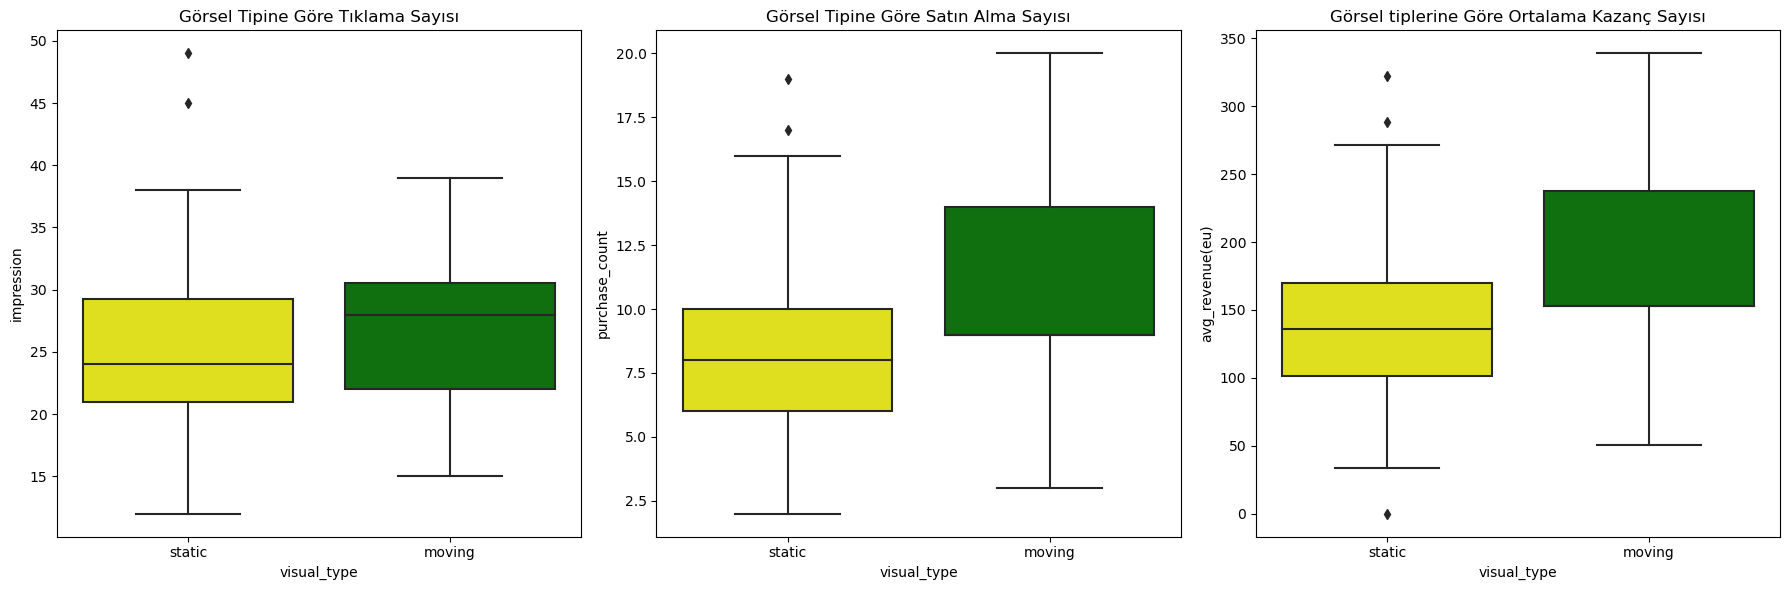

In [40]:
#Grafik için renk seçimi
palette = {'static': 'yellow', 'moving': 'green'}

# Boxplot oluşturma
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tıklama sayısı için box plot
sns.boxplot(x='visual_type', y='impression', data=df, ax=axes[0],palette=palette)
axes[0].set_title('Görsel Tipine Göre Tıklama Sayısı')

# Satın alma sayısı için box plot
sns.boxplot(x='visual_type', y='purchase_count', data=df, ax=axes[1],palette=palette)
axes[1].set_title('Görsel Tipine Göre Satın Alma Sayısı')

# Kazanç için box plot
sns.boxplot(x='visual_type', y='avg_revenue(eu)', data=df, ax=axes[2],palette=palette)
axes[2].set_title('Görsel tiplerine Göre Ortalama Kazanç Sayısı')

plt.tight_layout()
plt.show()

In [835]:
#Grafiklere göre, birkaç aykırı gözlem sayısı görülmektedir. Baskılama,silme ya da veri setinde bırakma gibi seçenekler
#değerlendirilebilir. Çok fazla olmadığı için veri setinde bırakmayı tercih ediyorum.

##### Veri setine ekleyeceğimiz metrikler:

In [ ]:
#click_rate: Tıklama oranı. Click Through Rate (CTR) olarak da bilinir ve tıklama sayısının gösterim sayısına oranıdır.
#purchase_rate: Satın alma oranı. Genellikle Conversion Rate (CR) olarak bilinir ve satın alma sayısının gösterim sayısına oranıdır.
# Bu metrikler satır bazında oranları ifade eder. Tüm veri seti için genel oranlar değilidir. 

In [68]:
df["click_rate"]=df["click_count"]/df["impression"]*100

In [70]:
df["purchase_rate"]=df["purchase_count"]/df["impression"]*100

In [272]:
df.tail(3) # Hesaplanmış iki sütunun da dataframe e eklenmiş olduğunu görüyoruz.

,day,visual_type,impression,click_count,purchase_count,avg_revenue(eu),click_rate,purchase_rate
117,59,moving,33,8,8,135.600000,24.242424,24.242424
118,60,static,36,14,2,33.900000,38.888889,5.555556
119,60,moving,34,15,16,271.200000,44.117647,47.058824


In [74]:
pivot_click_rate = df.pivot(index='day', columns='visual_type', values='click_rate')

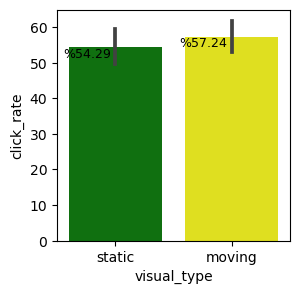

In [78]:
colors = ['green', 'yellow']
plt.figure(figsize=(3, 3))
ax=sns.barplot(x='visual_type', y='click_rate', data=df, palette=colors)
for p in ax.patches:
    ax.annotate(f'%{p.get_height():.2f}', (p.get_x() + p.get_width() / 5., p.get_height()),
                ha='center', va='top', fontsize=9, color='black') 
plt.show()

In [82]:
pivot_purchase_rate = df.pivot(index='day', columns='visual_type', values='purchase_rate')

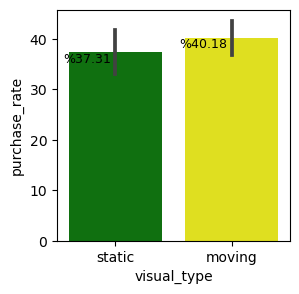

In [84]:
colors = ['green', 'yellow']
plt.figure(figsize=(3, 3))
ax=sns.barplot(x='visual_type', y='purchase_rate', data=df, palette=colors)
for p in ax.patches:
    ax.annotate(f'%{p.get_height():.2f}', (p.get_x() + p.get_width() / 5., p.get_height()),
                ha='center', va='top', fontsize=9, color='black') 
plt.show()

In [86]:
# Statik ve hareketli olarak değerleri ayıralım.
static_data = df[df['visual_type'] == 'static']
moving_data = df[df['visual_type'] == 'moving']

In [90]:
print("st- Click Mean:", static_data["click_count"].mean())
print("mv- Click Mean:", moving_data["click_count"].mean())

st- Click Mean: 13.083333333333334
mv- Click Mean: 15.133333333333333


Genel olarak, grafiklere baktığımızda bazı farklılıklar olduğu görülüyor. 
Bu farklılıkların istatiksel olarak anlamlı olup olmadığına bakmak için AB testi yapılır.

#### AB TEST ORTALAMA KARŞILAŞTIRMA

In [803]:
# İKİ GRUP FARKLILIKLARINI KARŞILAŞTIRMAK İÇİN "BAĞIMSIZ ÖRNEKLEM T TESTİ" YA DA  "MANN WHITNEY U TESTI" KULLANILIR.
# "BAĞIMSIZ ÖRNEKLEM T TESTİ"İÇİN 2 VARSAYIMIN SAĞLANMASI GEREKMEKTEDİR. BU VARSAYIMLAR:

# 1.Varsayım: "Normallik Varsayımı"--Verilerin normal dağılıma uygun olması anlamına gelir. 
# Normal dağılım, çan eğrisi olarak bilinen simetrik bir dağılım şeklidir.
# Saphiro-Wilk Testi ile kontrol edilir.

# 2.Varsayım "Varyans Homojenliği Varsayımı"--Farklı gruplardaki verilerin varyanslarının (dağılımlarının) eşit olması anlamına gelir. 
# Gruplar arasındaki değişkenlik benzer olmalıdır.
# Levene Testi ile kontrol edilir.

## EĞER NORMALLİK VARSAYIMI SAĞLANMIYORSA, DİREKT "MANN WHITNEY U TESTI" KULLANILIR.
## EĞER NORMALLİK VARSAYIMI SAĞLANIYORSA, HOMOJENLİK VARSAYIMINA GEÇİLİR. 
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANIYORSA, "BAĞIMSIZ ÖRNEKLEM T TESTİ" KULLANILIR.
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANMIYORSA,"BAĞIMSIZ ÖRNEKLEM T TESTİ-(WELCH)" KULLANILIR.

#### 1.HİPOTEZ TESTİ: TIKLAMA ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Statik görsel ve hareketli görsel tıklanma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ve hareketli görsel tıklanma ortalamaları arasında fark vardır.

In [ ]:
#Bu hipotez testini yapmak için ilk önce normallik varsayımına bakalım.

##### 1.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [110]:
#Shapiro-Wilk Testi
test_stat, static_pvalue = shapiro(static_data["click_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, static_pvalue)) #normallik varsayımı için shapiro-wilk testi kullanılır.
test_stat, moving_pvalue = shapiro(moving_data["click_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, moving_pvalue))

Test Stat = 0.9339, p-value = 0.0029
Test Stat = 0.9881, p-value = 0.8265


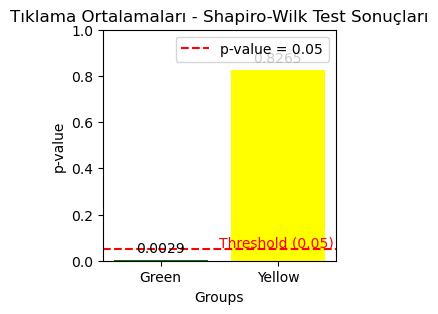

In [112]:
#Shapiro-Wilk Testi-p_value değeri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [static_pvalue, moving_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Tıklama Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

green_p-value = 0.0029<0.05 olduğundan, H0 reddedilir. Statik görsel değerleri için normal dağılım varsayımı sağlanmamaktadır.

yellow_p-value = 0.8265>0.05 olduğundan, H0 reddedilemez. Hareketli görsel değerleri için normal dağılım varsayımı sağlanmaktadır.

##### Normallik varsayımında değerlerden biri normallik varsayımına uymuyorsa, direkt non-parametrik test olan "MANN WHITNEY U" TESTİ" yapılmasına karar verilir. 

##### Varyans homojenliğine bakmaya gerek yoktur.

##### Mann-Whitney U testi, bağımsız iki grup arasındaki medyan farklılıklarını test etmek için kullanılan bir non-parametrik testtir.


In [121]:
#Mann Whitney U Testi
test_stat, mwh_pvalue = stats.mannwhitneyu(static_data["click_count"],
                              moving_data["click_count"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, mwh_pvalue))

Test Stat = 1272.0000, p-value = 0.0055


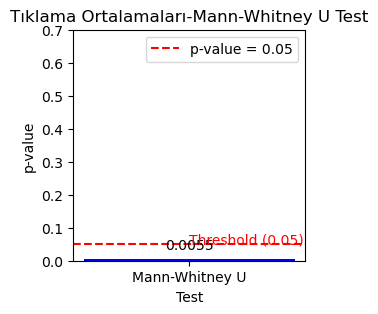

In [125]:
#Mann Whitney U Testi- p_value için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [mwh_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Tıklama Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

p-value = 0.0055<0.05 olduğundan H0 reddedilir.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Statik görsel ve hareketli görsel tıklanma ortalamaları arasında fark yoktur. REDDEDİLİR.

##### %95 güvenle statik görsel ve hareketli görselleri tıklanma ortalamaları arasında istatistiksel olarak anlamlı bir fark  vardır.

#### 2.HİPOTEZ TESTİ: SATIN ALMA/PURCHASE ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Statik görsel ve hareketli görsel ile satın alma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ve hareketli görsel ile satın alma ortalamaları arasında fark vardır.

##### 2.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [141]:
#Shapiro-Wilk Testi
test_stat, st_pvalue = shapiro(static_data["purchase_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, st_pvalue)) 
test_stat, mv_pvalue = shapiro(moving_data["purchase_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, mv_pvalue))

Test Stat = 0.9348, p-value = 0.0032
Test Stat = 0.9600, p-value = 0.0468


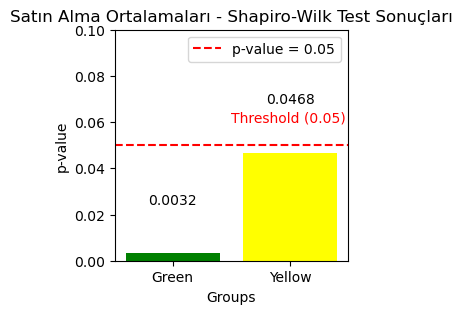

In [143]:
#Shapiro-Wilk Testi p_value değerleri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [st_pvalue, mv_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Satın Alma Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

st_p-value = 0.0032<0.05 olduğunda H0 reddedilir.

mv_p-value = 0.0468<0.05 olduğundan H0 reddedilir.

Normal dağılım varsayımı sağlanmamaktadır. Bu nedenle, varyans homojenliğine bakmaya gerek yoktur.

Whitney U testi yapılmasına karar verilir.

In [145]:
#Mann Whitney U Testi
test_stat, pr_pvalue = stats.mannwhitneyu(static_data["purchase_count"],
                              moving_data["purchase_count"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pr_pvalue))

Test Stat = 1211.5000, p-value = 0.0018


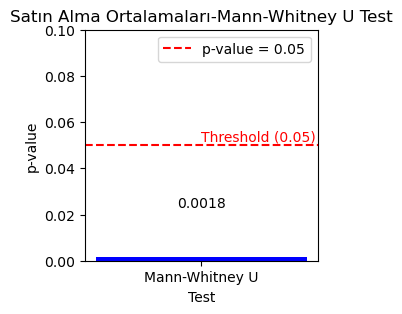

In [155]:
#Mann Whitney U Testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [pr_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

p-value = 0.018<0.05 olduğundan H0 reddedilir.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Statik görsel ve hareketli görsel ile satın alma ortalamaları arasında fark yoktur.

#####  %95 güvenle statik görsel ve hareketli görselile satın alma ortalamaları arasında istatistiksel olarak anlamlı bir fark vardır.

#### 3.HİPOTEZ TESTİ: KAZANÇ/GELİR ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Statik görsel ve hareketli görsel ile elde edilen gelir ortalamaları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ve hareketli görsel ile elde edilen gelir ortalamaları arasında fark vardır.


##### 3.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [168]:
#Shapiro-Wilk Testi
test_stat, s_pvalue = shapiro(static_data["avg_revenue(eu)"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, s_pvalue)) 
test_stat, m_pvalue = shapiro(moving_data["avg_revenue(eu)"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, m_pvalue))

Test Stat = 0.9510, p-value = 0.0174
Test Stat = 0.9600, p-value = 0.0468


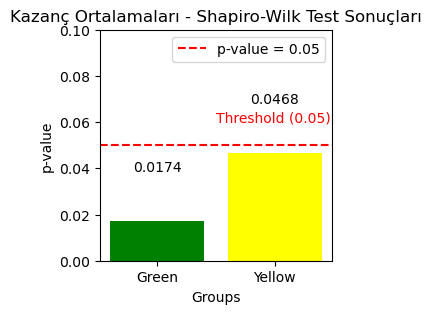

In [172]:
#p_value değerleri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [s_pvalue, m_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Kazanç Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

p-value = 0.0174<0.05 olduğunda H0 reddedilir.

p-value = 0.0468<0.05 olduğundan H0 reddedilir.

##### Normal dağılım varsayımı sağlanmamaktadır. Bu nedenle, varyans homojenliğine bakmaya gerek yoktur.

##### Whitney U testi yapılmasına karar verilir.

In [175]:
#Mann Whitney U Testi
test_stat, av_pvalue = stats.mannwhitneyu(static_data["avg_revenue(eu)"],
                              moving_data["avg_revenue(eu)"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, av_pvalue))

Test Stat = 1200.5000, p-value = 0.0015


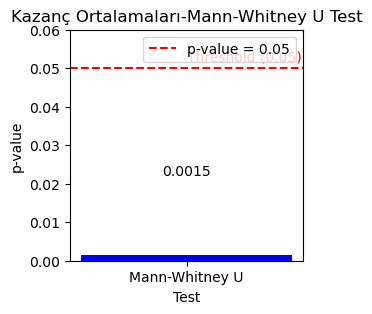

In [183]:
#Mann Whitney U Testi-p_value için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [av_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Kazanç Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height()  # Barın yüksekliği (p-value)
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.06)
plt.legend()
plt.show()

p-value = 0.0015<0.05 olduğundan H0 reddedilir.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Statik görsel ve hareketli görsel ile elde edilen gelir ortalamaları arasında fark yoktur.

#####  %95 güvenle statik görsel ve hareketli görsel ile elde edilen gelir ortalamaları arasında istatistiksel olarak anlamlı bir fark vardır.

In [ ]:
#Ortalamalara göre A/B test sonucu, statik görsel ile hareketli görsel arasında istatiksel olarak anlamlı bir fark olduğunu
#göstermektedir. Bu sonuca göre, reklam kampanyasında hareketli görsel kullanmak satın alma, tıklama ve kazanç ortalamasını olumlu
#yönde etkileyeceği düşünülmektedir.

#### AB TEST ORAN KARŞILAŞTIRMA

In [372]:
#İKİ GRUP ORANLARI ARASINDA KARŞILAŞTIRMA YAPMAK İÇİN KULLANILIR. VARSAYIM YOKTUR.
#"Z TESTİ",İKİ VEYA DAHA FAZLA BAĞIMSIZ GRUBUN BAŞARI ORANLARINI HESAPLAMAK İÇİN KULLANILIR.

#### 4.HİPOTEZ TESTİ: SATIN ALMA ORANLARI

H0 : M1 = M2 Statik görsel ve hareketli görsel ile tıklamalardan gelen satın alma oranları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ve hareketli görsel ile tıklamalardan gelen satın alma oranları arasında fark vardır.

Coversion Rate=Purchase/Click

Tıklama yapanların satın alma oranlarıdır. 

Satın alma sayı toplamının, tıklama sayısı toplamına bölünmesi ile bulunur.

Çıkan sayı 100 ile çarpılarak yüzdelik oran hesaplanır.

##### Coversion Rate için Hesaplama Yapalım

In [274]:
static_click_total= static_data["click_count"].sum()
static_purchase_total=static_data["purchase_count"].sum()
moving_click_total= moving_data["click_count"].sum()
moving_purchase_total=moving_data["purchase_count"].sum()

In [191]:
static_cr=round((static_purchase_total/static_click_total)*100,2)
moving_cr=round((moving_purchase_total/moving_click_total)*100,2)

In [193]:
print('Statik Görsel ile Satın Alma Oranı: %', static_cr,'\n'
     'Hareketli Görsel ile Satın Alma Oranı: %', moving_cr)

Statik Görsel ile Satın Alma Oranı: % 66.62 
Hareketli Görsel ile Satın Alma Oranı: % 70.15


In [197]:
#Z Testi
test_stat, ztest_pvalue = proportions_ztest(count=[static_purchase_total,moving_purchase_total],#count: Her grubun başarılı sonuç sayısı (örneğin, satın alma).
                                      nobs=[static_click_total, moving_click_total]) #nobs: Her grubun toplam deneme sayısı (örneğin, tıklama sayısı).
print('Test Stat = %.4f, p-value = %.4f' % (test_stat,ztest_pvalue))

Test Stat = -1.5595, p-value = 0.1189


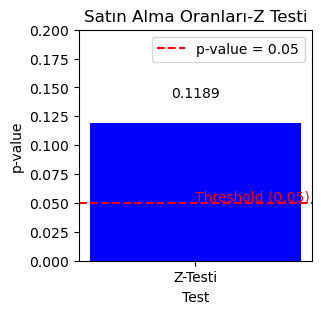

In [204]:
#Z testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Z-Testi']
p_values = [ztest_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Oranları-Z Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.2)
plt.legend()
plt.show()

p-value = 0.1189>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Statik görsel ve hareketli görsel ile tıklamalardan gelen satın alma oranları arasında fark yoktur.

##### %95 güvenle Statik görsel ve hareketli görsel ile tıklamalardan gelen satın alma oranları arasında istatistiksel olarak anlamlı bir fark yoktur.

#### 5.HİPOTEZ TESTİ: KAZANÇ ORANLARI

H0 : M1 = M2 Statik görsel ile hareketli görsellere tıklamalardan gelen kazanç oranları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ile hareketli görsellere tıklamalardan gelen kazanç oranları arasında fark vardır.

Click Through Rate=Avg. Revenue Sayısı / Click

Görsellere tıklanarak kazanılan gelir/kazanç oranlarıdır.

Geliri ifade eden satır sayısı (satın alma sayısı), toplam tıklama/click sayısına bölünür.

Çıkan sayı 100 ile çarpılarak yüzdelik oran bulunur.



#### Click Trough Rate değeri için ilgili hesaplamaları yapalım

In [216]:
static_rev_count=static_data["avg_revenue(eu)"].count()
static_click_total= static_data["click_count"].sum() #yukarıda hesaplamıştık. Hesaplama için bu değeri yine kullanacağız.
moving_rev_count=moving_data["avg_revenue(eu)"].count()
moving_click_total= moving_data["click_count"].sum() #Yukarıda hesaplamıştık. Hesaplama için bu değeri yine kullanacağız.

In [282]:
static_click_total

785

In [218]:
static_click_tr_rate = round((static_rev_count/static_click_total)*100,2)
moving_click_tr_rate= round((moving_rev_count/moving_click_total)*100,2)

In [220]:
print('Statik Görselden Elde Edilen Kazanç Oranı: %', static_click_tr_rate,'\n'
     'Hareketli Görselden Elde Edilen Kazanç Oranı: %', moving_click_tr_rate)

Statik Görselden Elde Edilen Kazanç Oranı: % 7.64 
Hareketli Görselden Elde Edilen Kazanç Oranı: % 6.61


In [222]:
#Z Testi
test_stat, zp_pvalue = proportions_ztest(count=[static_rev_count,moving_rev_count],#count: Her grubun başarılı sonuç sayısı (örneğin, satın alma).
                                      nobs=[static_click_total, moving_click_total]) #nobs: Her grubun toplam deneme sayısı (örneğin, tıklama sayısı).
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, zp_pvalue))

Test Stat = 0.8279, p-value = 0.4078


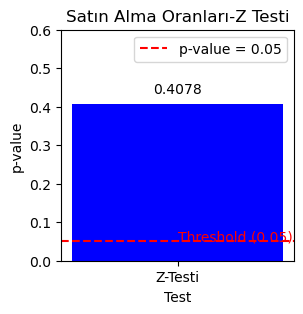

In [234]:
#Z testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Z-Testi']
p_values = [zp_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Oranları-Z Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.6)
plt.legend()
plt.show()

p-value = 0.4078>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Statik görsel ile hareketli görsellere tıklamalardan gelen kazanç oranları arasında fark yoktur.

#####  %95 güvenle statik görsel ile hareketli görsellere tıklamalardan gelen kazanç oranları arasında istatiksel olarak anlamlı bir fark yoktur.

#### Ortalama ve orana göre test sonuçlarını değerlendirdiğimizde, satın alma ortalamalarında anlamlı bir farkın bulunması kullanıcıların görsel türüne göre farklılık gösteren davranışlar sergilediğini ortaya koymaktadır. 

#### Ancak satın alma oranlarında böyle bir farkın olmaması, kullanıcıların karar verme süreçlerinin daha karmaşık olduğunu düşündürüyor. Görsellere tıkladıktan sonra kararlarını etkileyen başka bir durum ya da durumların varlığı söz konusu olabilir. 

#### Farklı görsel türlerinin yanı sıra, fiyat, promosyonlar, ürün açıklamaları gibi farklı değişkenleri de test etmek daha doğru kararlar almak için iyi olabilir. 

## NOT:

#### AB TEST ORTALAMA KARŞILAŞTIRMA

In [806]:
# İKİ GRUP FARKLILIKLARINI KARŞILAŞTIRMAK İÇİN "BAĞIMSIZ ÖRNEKLEM T TESTİ" YA DA  "MANN WHITNEY U TESTI" KULLANILIR.
# "BAĞIMSIZ ÖRNEKLEM T TESTİ"İÇİN 2 VARSAYIMIN SAĞLANMASI GEREKMEKTEDİR. BU VARSAYIMLAR:

# 1.Varsayım: "Normallik Varsayımı"--Verilerin normal dağılıma uygun olması anlamına gelir. 
# Normal dağılım, çan eğrisi olarak bilinen simetrik bir dağılım şeklidir.
# Saphiro-Wilk Testi ile kontrol edilir.

# 2.Varsayım "Varyans Homojenliği Varsayımı"--Farklı gruplardaki verilerin varyanslarının (dağılımlarının) eşit olması anlamına gelir. 
# Gruplar arasındaki değişkenlik benzer olmalıdır.
# Levene Testi ile kontrol edilir.

## EĞER NORMALLİK VARSAYIMI SAĞLANMIYORSA, DİREKT MANN WHITNEY U TESTI KULLANILIR.
## EĞER NORMALLİK VARSAYIMI SAĞLANIYORSA, HOMOJENLİK VARSAYIMINA GEÇİLİR. 
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANIYORSA, "BAĞIMSIZ ÖRNEKLEM T TESTİ" KULLANILIR.
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANMIYORSA,"BAĞIMSIZ ÖRNEKLEM T TESTİ-(WELCH)" KULLANILIR.

Yukarıdaki örnekte her iki değerde aynı anda normallik dağılımı şartı sağlanamadığı için varyans homojenliği yapılamadı.
Bu nedenle, varyans homojenliğini incelemek için aşağıdaki örneğe bakalım:

Örnek, sadece varyans homojenliği uygulaması ve sonuçta hipotez doğruluğu için kullanılmaya karar verilecek test kararının nasıl olduğu ile ilgilidir. Tam bir örneklemi yansıtamamakla beraber gerçek değerlerden oluşmamaktadır. 

#### Rastgele Değerlerden bir Dataframe oluşturalım:

In [251]:
statik_purchase_count_datas = [665, 315, 458, 487, 441, 519, 512, 747]
df_st = pd.DataFrame(statik_purchase_count_datas, columns=['purchase_count'])

moving_purchase_count_datas = [702, 834, 422, 429, 749, 778, 491]
df_mv = pd.DataFrame(moving_purchase_count_datas, columns=['purchase_count'])

#### HİPOTEZ TESTİ: SATIN ALMA  ORTALAMALARI

H0 : M1 = M2 Statik görsel ve  hareketli görsel ile satın alma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Statik görsel ve  hareketli görsel ile satın alma ortalamaları arasında fark vardır.


##### NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [253]:
static_test_stat, df_st_p_value = shapiro(df_st["purchase_count"])
moving_test_stat, df_mv_p_value = shapiro(df_mv["purchase_count"])

print('Statik_Test Stat = %.4f, green_p-value = %.4f' % (static_test_stat, df_st_p_value))
print('Hareketli_Test Stat = %.4f, yellow_p-value = %.4f' % (moving_test_stat, df_mv_p_value))

Statik_Test Stat = 0.9426, green_p-value = 0.6367
Hareketli_Test Stat = 0.8561, yellow_p-value = 0.1397


green_p-value = 0.6367>0.05 olduğundan H0 reddedilemez.

H0 : Normal dağılım varsayımı sağlanmaktadır.

yellow_p-value = 0.1397 >0.05 olduğundan H0 reddedilemez.

H0 : Normal dağılım varsayımı sağlanmaktadır.

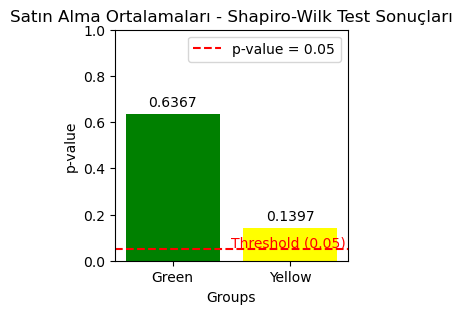

In [817]:
groups = ['Green', 'Yellow']
p_values = [df_green_p_value, df_yellow_p_value]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Satın Alma Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

Her iki değer için normallik varsayımı sağlandığı için varyans homojenliği varsayımı kontrol edilir. Bunun için,"LEVENE TESTİ" uygulanır.
Bu test sonucuna göre, "BAĞIMSIZ ÖRNEKLEM T TESTİ" ya da "BAĞIMSIZ ÖRNEKLEM T TESTİ-welch" uygulanmasına karar verilir.

#### VARYANS HOMOJENLİĞİ VARSAYIMI (LEVENE TESTİ)

H0: Varyanslar Homojendir.

H1: Varyanslar Homojen Değildir.

In [259]:
test_stat, vy_pvalue = levene(df_st["purchase_count"],
                           df_mv["purchase_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, vy_pvalue))

Test Stat = 1.0088, p-value = 0.3335


p-value = 0.3335>0.05 olduğundan H0 reddilemez . Varyans homojenliği sağlanmıştır. 

Varyans Homojenliği sağlandığı için "BAĞIMSIZ ÖRNEKLEM T TESTİ" uygulanır.

In [261]:
test_stat, gorsel_pvalue = ttest_ind(df_st['purchase_count'],
                              df_mv['purchase_count'],
                              equal_var=True)  # varyans homojenliği olmasaydı, "equal_var=False" yapmamız gerekirdi. BAĞIMSIZ ÖRNEKLEM T TESTİ-welch testi kullanmış olurduk.

In [265]:
gorsel_pvalue 

0.18823050184905096

0.188>0.05 olduğundan H0 reddedilemez. 
H0 : M1 = M2 Statik görsel ve hareketli görsel ile satın alma ortalamaları arasında fark yoktur.

##### %95 güvenle Statik görsel ve hareketli görsel ile tıklamalardan gelen satın alma ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.

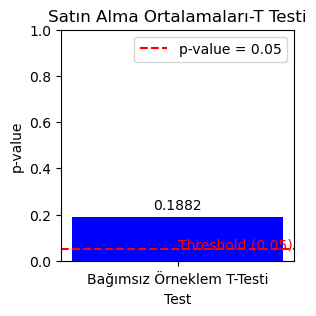

In [268]:
plt.figure(figsize=(3,3))
groups = ['Bağımsız Örneklem T-Testi']
p_values = [gorsel_pvalue ]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Ortalamaları-T Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()